# Load the Trained Model

In [3]:
import sys, os
sys.path.append(os.path.abspath(".."))  # This adds project root to Python path


In [4]:
import torch
from src.model import PlantDiseaseCNN

# Init model (must match original architecture)
model = PlantDiseaseCNN(num_classes=15)
model.load_state_dict(torch.load("../outputs/plant_disease_cnn.pth"))
model.eval()  # Set to inference mode


PlantDiseaseCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=15, bias=True)
)

##  Load Validation Set

In [5]:
from src.data import get_loaders

# Load validation loader only
_, val_loader = get_loaders("../data/PlantVillage", img_size=224, batch_size=32)


##  Run Inference + Collect Labels & Predictions

In [6]:
import torch
import numpy as np

model.eval()  # ensure eval mode

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(model.fc2.weight.device)  # send to same device as model
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


## Confusion Matrix

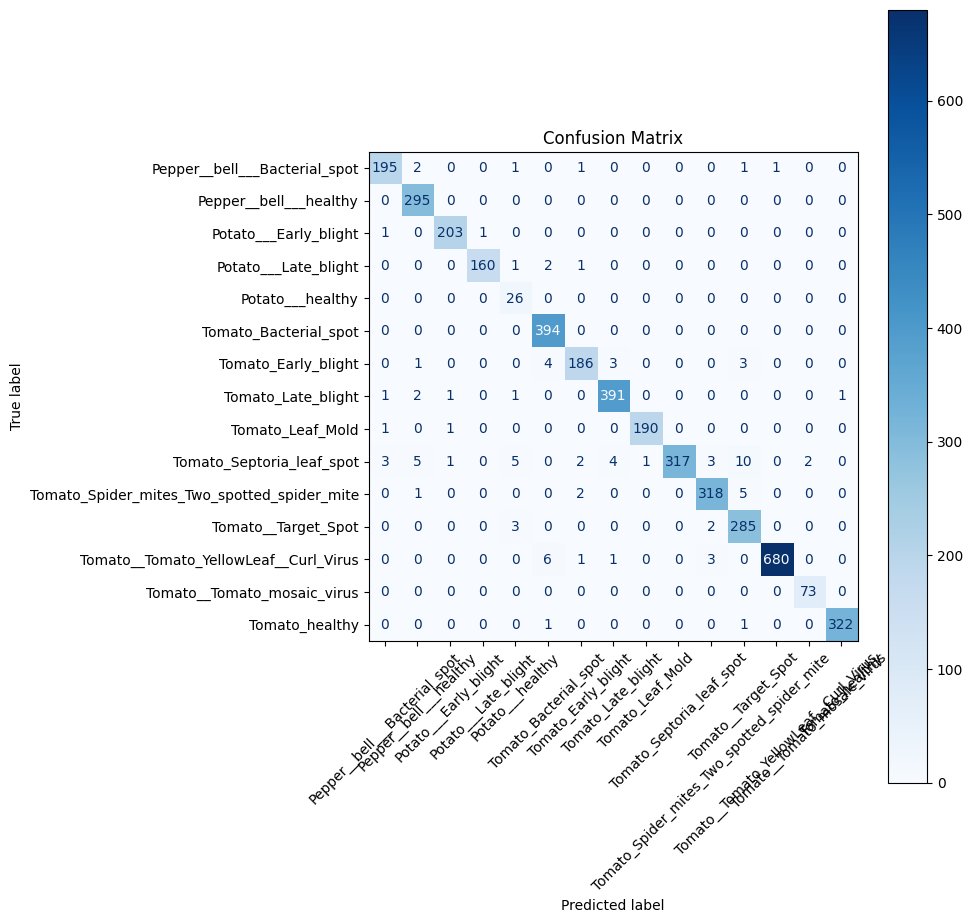

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load class names
dataset = val_loader.dataset
class_names = dataset.dataset.classes  # because val_loader uses Subset

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../outputs/figures/confusion_matrix.png")
plt.show()


### The model was evaluated on the validation set. The confusion matrix indicates strong performance, with most classes well classified. Misclassifications are mainly seen between visually similar diseases (e.g., early and late blight).


# ROC Curves

### Get Probabilities (not just predicted class)

In [9]:
from sklearn.preprocessing import label_binarize

model.eval()
all_probs = []
all_true = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(model.fc2.weight.device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_true.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)   # shape: [N, 15]
all_true = np.concatenate(all_true, axis=0)     # shape: [N]


### Binarize Labels for One-vs-All

In [10]:
from sklearn.metrics import roc_curve, auc

n_classes = all_probs.shape[1]
y_true_bin = label_binarize(all_true, classes=range(n_classes))  # shape: [N, 15]


### Plot ROC Curves

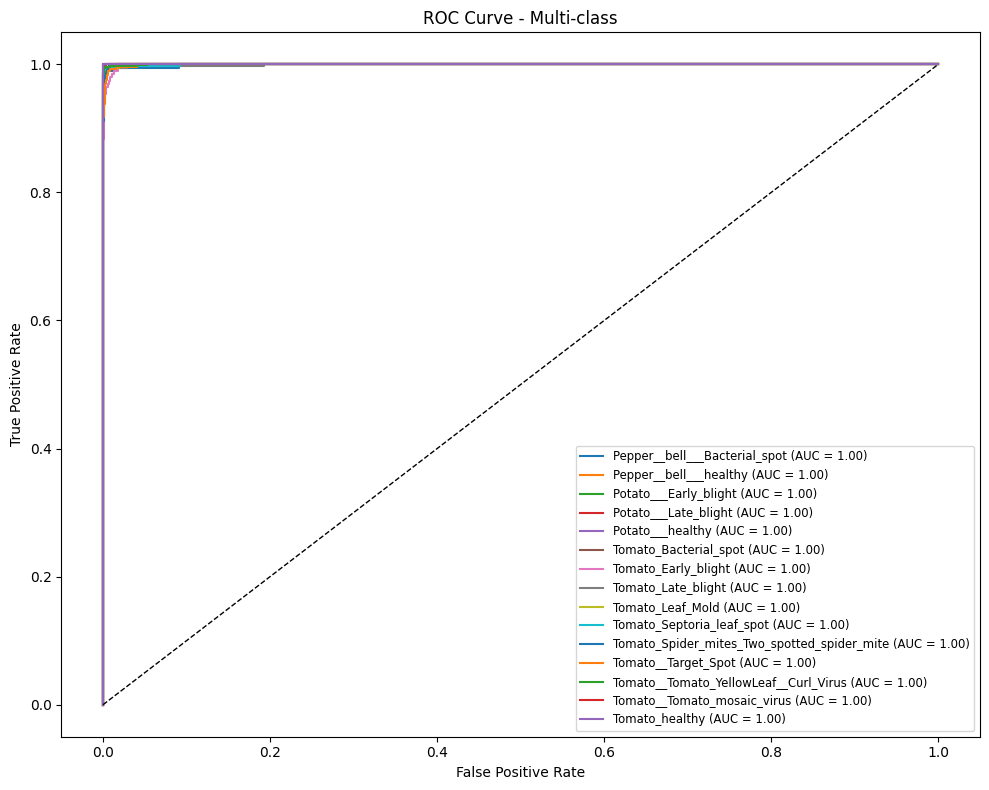

In [12]:
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-class")
plt.legend(loc="lower right", fontsize='small')
plt.tight_layout()
plt.savefig("../outputs/figures/roc_curve_multiclass.png")
plt.show()


### Conclusion
- Validation accuracy reached 94.5%

- Confusion matrix shows minimal misclassification

- ROC curves show AUC = 1.00 for all 15 classes

- Model demonstrates strong class separability

- Performs well on clean, labeled dataset
